In [11]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

In [2]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

## inspect natural data for a test subject

In [51]:
test_subject_idx = 10
test_subject = subjects[test_subject_idx]

(681, 2) (607, 2)


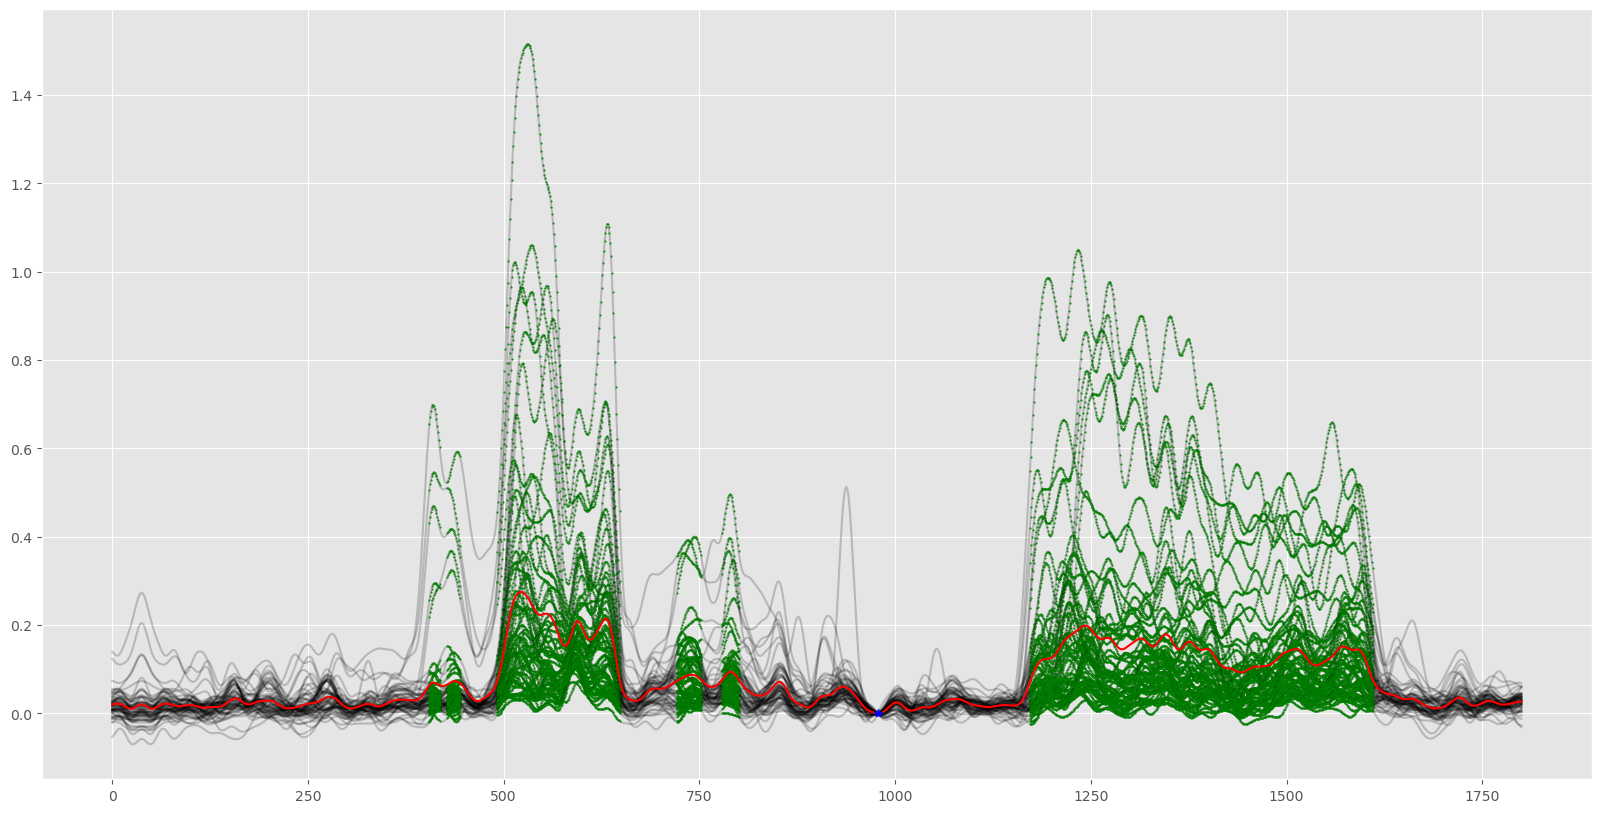

In [35]:
### load one trial of natural movement data

filenames = analysis.get_movement_filenames("emg_olympics", test_subject.name, "natural_movement", "session_0")
signal = analysis.load_movement_emg(filenames[5])
filtered = emg.filter_emg(signal, test_subject.variance)
indices, low_point, mean_norm_threshold = analysis.find_nat_movement_active_indices(filtered)
# 1000, 64
X = filtered[indices]
# 1000, 2
projected_movement = X @ test_subject.decoder[-2:,:].T


### trial data

trial = test_subject.tasks[task_name].sorted_sessions()[0].sorted_trials()[4]
X = trial.get_filtered_emg()[trial.active_indices]
T = X @ test_subject.decoder[-2:,:].T

print(projected_movement.shape, T.shape)

fig, ax = plt.subplots(1,1,figsize=(20,10))

filtered -= filtered[low_point]

for channel in range(64):
    ax.plot(filtered[:, channel], "k", alpha=0.2)
    ax.plot(indices, filtered[indices, channel], "g.", markersize=1)

mean_sig = np.mean(filtered,axis=1)
ax.plot(mean_sig, "r")
ax.plot(low_point, mean_sig[low_point], "b*")

## make natural movement data brick over subjects

In [ ]:
subject_movement_stacks = np.empty(shape=(len(subjects), 28, 64))
subject_movement_stacks[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    subject_movement_stacks[subject_idx,:,:] = analysis.load_movement_stack(subject)

np.save(Path.cwd() / "subject_natural_movement_stacks.npy", subject_movement_stacks)

In [45]:
def load_jagged_movement_stack(subject):

    # more than enough room for the active indices
    # session, movement, channel, time
    movement_emg = np.empty(shape=(2,14,64,1800))
    movement_emg[:] = np.nan

    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = analysis.get_movement_filenames("emg_olympics", subject.name, "natural_movement", session_name)
        for movement_idx, filename in enumerate(filenames):
            signal = analysis.load_movement_emg(filename)
            filtered = emg.filter_emg(signal, subject.variance)
            indices, low_point, mean_norm_threshold = analysis.find_nat_movement_active_indices(filtered)
            movement_emg[session_idx,movement_idx,:,:indices.shape[0]] = (filtered[indices] - filtered[low_point]).T

    return movement_emg

jms = load_jagged_movement_stack(test_subject)

In [46]:
print(jms[0,0].shape)

(64, 1800)


In [43]:
def plot_movement_channels(ax, sig):
    for channel in range(64):
        ax.plot(sig[:, channel], "k", alpha=0.2)
    mean_sig = np.mean(sig,axis=1)
    ax.plot(mean_sig, "r")

<Axes: >

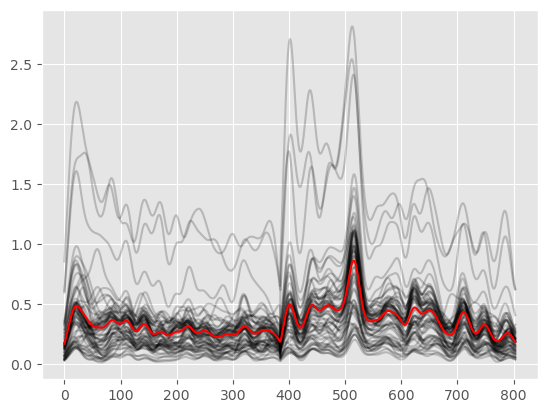

In [42]:
fig, ax = plt.subplots(1,1)
plot_movement_channels(ax, jms[0,6].T)

In [47]:
# subject_movement_stacks = []
# for subject in subjects:
#     subject_movement_stacks.append(load_jagged_movement_stack(test_subject))
# print(len(subject_movement_stacks))
# subject_movement_stacks = np.array(subject_movement_stacks)
# subject_movement_stacks.shape
# np.save("subject_movement_stacks.npy", subject_movement_stacks)

46


## save it to disk!

In [52]:
subject_movement_stacks = np.load("subject_movement_stacks.npy")
subject_movement_stacks.shape

(46, 2, 14, 64, 1800)

## run through the decoder, plot

In [62]:
import seaborn as sns
import pandas as pd

In [63]:
subject_movement = subject_movement_stacks[test_subject_idx,:,:,:].reshape(-1,64)
subject_trajectories = pd.DataFrame(subject_movement @ test_subject.decoder[-2:,:].T, columns=['x','y'])


(-1.0, 1.0)

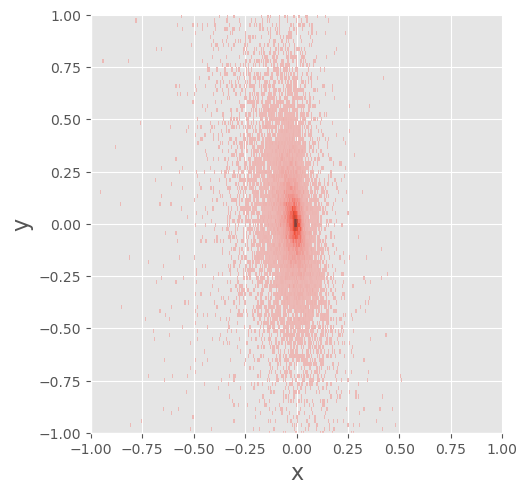

In [68]:
sns.displot(subject_trajectories,x="x",y="y",kind="hist")
plt.xlim([-1,1])
plt.ylim([-1,1])